<a href="https://colab.research.google.com/github/lszam/gds-ssebrazil/blob/main/GDS_SSEBrazil_Etapa2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Etapa 2 - Analise dos dados**

Este arquivo foi desenvolvido para ser executado em ambiente Google Colab.


# **Preparar o ambiente - bibliotecas e funções**

In [60]:
!pip install geopandas shapely matplotlib zipfile36 verde scikit-learn -q

import zipfile
import os
import re
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import verde as vd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import BallTree



def download_file(url, save_path='/content/grav.zip'):
    '''
    Função para baixar arquivos do Google Drive
    '''
    import requests

    response = requests.get(url)
    with open(save_path, 'wb') as file:
        file.write(response.content)
    return save_path

def unzip_files(file_path, extract_dir='/content/extracted_shapefiles'):
    '''
    Função para descompactar arquivos .zip no Google Colab
    '''
    os.makedirs(extract_dir, exist_ok=True)
    shapefiles = []
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
        shapefiles = [os.path.join(extract_dir, name) for name in zip_ref.namelist() if name.endswith('.shp')]
    return shapefiles


def load_shapefile(file_path):
    '''
    Função para carregar shapefiles
    '''
    gdf = gpd.read_file(file_path)
    if gdf.crs is None:
        gdf.set_crs("EPSG:4674", inplace=True)  # Definir como SIRGAS 2000
    else:
        gdf = gdf.to_crs("EPSG:4674")
    return gdf


def plot_2maps(gdf1, title1, color1, gdf2, title2, color2, brasil_contour):
    """
    Função para plotar dois mapas do Brasil, para situações onde seja necessário comparar dados.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 2 subplots

    # Mapa de pontos que vão ser considerados no projeto
    brasil_contour.plot(ax=axes[0], color='none', edgecolor='black')
    gdf1.plot(ax=axes[0], color=color1, markersize=0.5, alpha=0.7)
    axes[0].set_title(title1, fontsize=16)
    axes[0].set_xlabel('Longitude', fontsize=14)
    axes[0].set_ylabel('Latitude', fontsize=14)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].grid(True)

    # Mapa com pontos duplicados, que serão retirados
    brasil_contour.plot(ax=axes[1], color='none', edgecolor='black')
    gdf2.plot(ax=axes[1], color=color2, markersize=5, alpha=0.7)
    axes[1].set_title(title2, fontsize=16)
    axes[1].set_xlabel('Longitude', fontsize=14)
    axes[1].set_ylabel('Latitude', fontsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

def recortar_area(gdf, lat_min, lat_max, lon_min, lon_max):
    '''
    Recortar a área usando a biblioteca Verde
    '''
    import verde as vd

    region = (lon_min, lon_max, lat_min, lat_max)
    mask = vd.inside((gdf['LONGITUDE'].values, gdf['LATITUDE'].values), region)
    gdf_recortado = gdf[mask]

    return gdf_recortado



In [77]:
a = '222.333.444'
a = str(a).strip()
a

'222.333.444'

In [78]:
a.count('.')

2

In [79]:
if a.count('.') > 1:
    parts = a.split('.')
    a = ''.join(parts[:-1]) + '.' + parts[-1]

a

'222333.444'

In [80]:
a = a.replace(',', '.')
a

'222333.444'

funções para tratar os dados espúrios

In [81]:

def correct_grav_obs_value(value):
    """
    Função para corrigir valores da coluna GRAV_OBS:
    - Remove múltiplos pontos, mantendo apenas o último
    - Substitui vírgulas por pontos
    - Remove caracteres não numéricos
    """
    if pd.isnull(value):
        return value  # Retorna o valor original se for NaN

    # Garantir que o valor é uma string e remover espaços extras
    value = str(value).strip()

    # Substituir vírgulas por pontos
    value = value.replace(',', '.')

    # Se o valor não for uma string válida, retornar None
    if not isinstance(value, str) or value == '':
        return None

    # Corrigir múltiplos pontos, mantendo apenas o último
    if value.count('.') > 1:
        parts = value.split('.')
        value = ''.join(parts[:-1]) + '.' + parts[-1]

    # Converter para float, se possível
    try:
        return float(value)
    except ValueError:
        print ('Erro ao corrigir:', value)
        return None


A fórmula Haversine pode ser usada para calcular a distância na esfera. Ela considera a curvatura da terra, mas pressupõe uma terra esférica em vez de um elipsoide. Para longas distâncias, a fórmula Haversine introduz um erro de menos de 0,1%. A altitude não é usada para calcular a distância. Mais em Microsoft Learn https://learn.microsoft.com/pt-br/dotnet/api/system.device.location.geocoordinate.getdistanceto?view=netframework-4.8.1



In [95]:

def haversine(lon1, lat1, lon2, lat2):
    """
    Calcula a distância entre dois pontos em km usando a fórmula de Haversine.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # Raio médio da Terra em km
    return km

# Função para encontrar pontos dentro de uma janela de raio específico
def find_neighbors(gdf, index, window_size_km):
    """Encontra todos os pontos dentro de uma janela de raio específico em km."""
    lon, lat = gdf.loc[index, ['LONGITUDE', 'LATITUDE']]
    distances = gdf.apply(lambda row: haversine(lon, lat, row['LONGITUDE'], row['LATITUDE']), axis=1)
    neighbors = gdf[distances <= window_size_km]
    return neighbors

# Função para detectar outliers usando LocalOutlierFactor (LOF)
from sklearn.neighbors import BallTree, LocalOutlierFactor
from shapely.geometry import Point



def detect_outliers_lof(gdf, window_size_km=50, n_neighbors=5):
    """
    Detecta outliers usando Local Outlier Factor (LOF) com opção de ignorar valores NaN.

    Parâmetros:
    - gdf: GeoDataFrame com os dados
    - window_size_km: Tamanho da janela de vizinhança em quilômetros
    - n_neighbors: Número de vizinhos a considerar no LOF

    Retorna:
    - GeoDataFrame atualizado com uma coluna 'OUTLIER' marcando os outliers
    """
    # Remover valores NaN antes de aplicar o LOF
    initial_count = len(gdf)
    gdf_clean = gdf.dropna(subset=['GRAV_OBS'])
    nan_count = initial_count - len(gdf_clean)

    if nan_count > 0:
        print(f"Excluindo {nan_count} valores com NaN na coluna 'GRAV_OBS' antes da análise de outliers.")

    # Preparar os dados para o modelo LOF
    X = gdf_clean[['GRAV_OBS']].values.reshape(-1, 1)

    # Aplicar o Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    gdf_clean['OUTLIER'] = lof.fit_predict(X)

    # Marcar -1 como outlier
    gdf_clean['OUTLIER'] = gdf_clean['OUTLIER'] == -1

    # Colocar os resultados com o GeoDataFrame original, preenchendo False para os registros que foram excluídos devido a NaN
    gdf = gdf.merge(gdf_clean[['OUTLIER']], how='left', left_index=True, right_index=True)
    gdf['OUTLIER'] = gdf['OUTLIER'].fillna(False)

    return gdf




def detect_outliers_iqr(gdf, window_size_km=50, multiplier=1.5):
    """
    Função para detectar outliers usando a análise de quartis (IQR) em janelas e usando BallTree.
    Desconsidera valores NaN antes da análise para evitar erro.
    """
    # Contar o número de valores iniciais
    initial_count = len(gdf)

    # Remover valores NaN da coluna 'GRAV_OBS'
    #gdf_clean = gdf.dropna(subset=['GRAV_OBS'])
    gdf_clean = gdf.dropna(subset=['GRAV_OBS'])
    nan_count = initial_count - len(gdf_clean)

    # Exibir quantos pontos foram desconsiderados devido a NaN
    if nan_count > 0:
        print(f"Excluindo {nan_count} valores com NaN na coluna 'GRAV_OBS' antes da análise de outliers.")

    # Converter coordenadas de LAT/LONG para radianos para uso no BallTree
    gdf_clean['LAT_RAD'] = np.radians(gdf_clean['LATITUDE'])
    gdf_clean['LON_RAD'] = np.radians(gdf_clean['LONGITUDE'])

    # Criar uma matriz de coordenadas para o BallTree
    coords = np.vstack((gdf_clean['LAT_RAD'], gdf_clean['LON_RAD'])).T
    tree = BallTree(coords, metric='haversine')

    # Inicializar a coluna OUTLIER como False
    gdf_clean['OUTLIER'] = False

    # Converter o tamanho da janela de km para radianos
    window_size_rad = window_size_km / 6371.0  # 6371 é o raio médio da Terra em km

    # Loop otimizado para detectar outliers usando IQR
    for idx in gdf_clean.index:
        # Encontrar vizinhos dentro da janela usando BallTree
        neighbors_idx = tree.query_radius([coords[idx]], r=window_size_rad)[0]

        if len(neighbors_idx) > 5:  # Apenas analisar se houver vizinhos suficientes
            neighbors = gdf_clean.iloc[neighbors_idx]

            # Calcular IQR para os vizinhos
            Q1 = neighbors['GRAV_OBS'].quantile(0.25)
            Q3 = neighbors['GRAV_OBS'].quantile(0.75)
            IQR = Q3 - Q1

            # Definir os limites usando o multiplicador ajustável
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR

            # Verificar se o ponto atual é um outlier
            value = gdf_clean.at[idx, 'GRAV_OBS']
            if value < lower_bound or value > upper_bound:
                gdf_clean.at[idx, 'OUTLIER'] = True

    # Remover colunas temporárias
    gdf_clean.drop(columns=['LAT_RAD', 'LON_RAD'], inplace=True)

    # Mesclar o resultado com o GeoDataFrame original, preenchendo com False para os valores removidos
    gdf = gdf.merge(gdf_clean[['OUTLIER']], how='left', left_index=True, right_index=True)
    gdf['OUTLIER'] = gdf['OUTLIER'].fillna(False)

    return gdf

# **Banco de dados**

In [82]:
# URL do arquivo zip
file_url = 'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/step1_data/grav.zip'

# Baixar arquivo zip
downloaded_file = download_file(file_url)

# Descompactar zip
shapefiles = unzip_files(downloaded_file)

# Verificar se o shapefile foi descompactado
if shapefiles:
    shapefile_path = shapefiles[0]  # Salvar o caminho do shapefile
    print(f"Shapefile encontrado: {shapefile_path}")
    gdf = load_shapefile(shapefile_path)
    print(f"Shapefile carregado com sucesso:\n{gdf.head()}")
else:
    print("Nenhum shapefile encontrado.")


Shapefile encontrado: /content/extracted_shapefiles/grav.shp
Shapefile carregado com sucesso:
       Line  LONGITUDE  LATITUDE INSTITUICA  ALT_ORTOME          GRAV_OBS  \
0  LEG_BNDG   -53.0153  -30.8142      UFRGS       258.0  979346.829999999   
1  LEG_BNDG   -53.9906  -30.7894      UFRGS       300.8  979337.359999999   
2  LEG_BNDG   -52.9597  -30.7919      UFRGS       207.2         979352.42   
3  LEG_BNDG   -53.0481  -30.8278      UFRGS       311.3  979336.449999999   
4  LEG_BNDG   -52.9661  -30.8386      UFRGS       190.7         979350.67   

   GRAV_ARLIV  GRAV_BOUGU FONTE     source_fil ALT_GEOM ALT_NORMAL SIGMALT_RN  \
0   38.179389        9.31  BNDG  bndg-2023-shp     None       None       None   
1   43.887957       10.23  BNDG  bndg-2023-shp     None       None       None   
2   29.864401        6.68  BNDG  bndg-2023-shp     None       None       None   
3   43.166784        8.33  BNDG  bndg-2023-shp     None       None       None   
4   19.310997       -2.03  BNDG  bndg-

Recortar o dado usando a biblioteca Verde

In [83]:
#lat_min = float(input("Informe a latitude mínima: ")) # -29.4958
#lat_max = float(input("Informe a latitude máxima: ")) # -21.7953
#lon_min = float(input("Informe a longitude mínima: ")) # -53.88964
#lon_max = float(input("Informe a longitude máxima: ")) # -44.10810
lat_min = -29.4958
lat_max = -21.7953
lon_min = -53.88964
lon_max = -44.10810

gdf_recortado = recortar_area(gdf, lat_min, lat_max, lon_min, lon_max)
print(f"Número de pontos na área recortada: {len(gdf_recortado)}")

Número de pontos na área recortada: 22307


In [24]:
# Baixar o shapefile das unidades da federação (UFs) do Brasil do site do IBGE
!wget -O brasil.zip https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip
!unzip brasil.zip -d /content/brasil_shapefile

brasil = gpd.read_file('/content/brasil_shapefile/BR_UF_2021.shp')

--2024-11-17 16:23:45--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13648228 (13M) [application/zip]
Saving to: ‘brasil.zip’

brasil.zip          100%[===================>]  13.02M  6.40MB/s    in 2.0s    

2024-11-17 16:23:48 (6.40 MB/s) - ‘brasil.zip’ saved [13648228/13648228]

Archive:  brasil.zip
replace /content/brasil_shapefile/BR_UF_2021.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

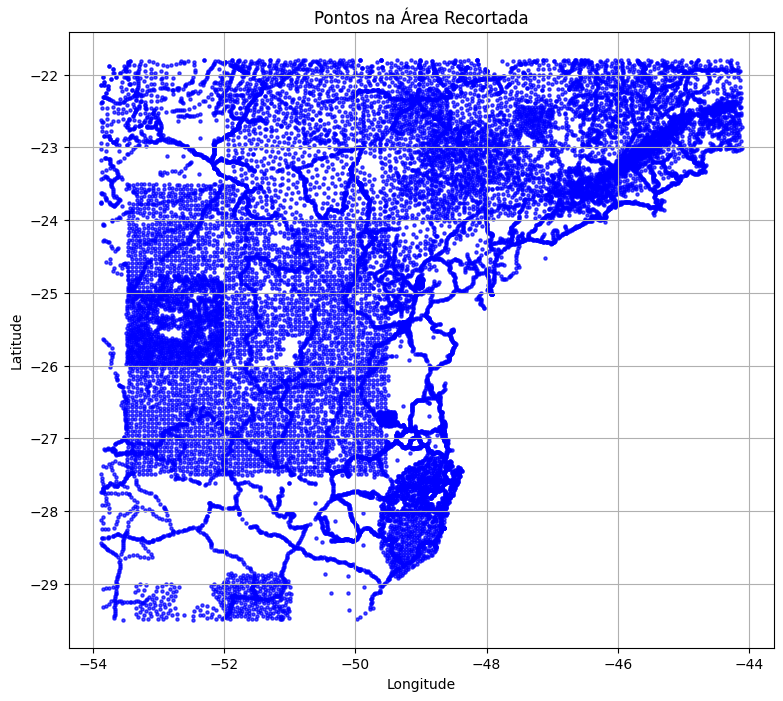

In [25]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))

#map = brasil.plot(color='none', edgecolor='black')
gdf_recortado.plot(ax=ax, color='blue', markersize=5, alpha=0.7)
plt.title("Pontos na Área Recortada")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [84]:
# Salvar e baixar os pontos recortados como um novo shapefile
output_dir = '/content/OUTPUT'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'grav-area.shp')
gdf_recortado.to_file(output_path)

# Compactar todos os arquivos do shapefile em um arquivo .zip
zip_output = '/content/OUTPUT/grav-area.zip'
with zipfile.ZipFile(zip_output, 'w') as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, output_dir))

# Fazer download do arquivo .zip
from google.colab import files
files.download(zip_output)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Tratamento de dados espúrios**

Análise convolucional dos valores de GRAV_OBS em uma janela móvel, para detectar e tratar outliers. Para localizar os outliers, usamos a biblioteca scikit-learn (LocalOutlierFactor, de sklearn.neighbors)

## Manter apenas dados necessários

Primeiro, vamos manter no objeto geopandas apenas as colunas necessárias (coordenadas, gravidade, e altitude ortométrica)

In [137]:
gdf = gpd.read_file('/content/OUTPUT/grav-area.shp')
columns_to_keep = ['LATITUDE', 'LONGITUDE', 'GRAV_OBS', 'ALT_ORTOME']
missing_columns = [col for col in columns_to_keep if col not in gdf.columns]

if missing_columns:
    print(f"As seguintes colunas estão faltando: {missing_columns}")
else:
    # Manter apenas as colunas desejadas
    gdf = gdf[columns_to_keep]
    print("\nDados filtrados com as colunas desejadas:")
    print(gdf.head(10))

# Exibir uma amostra dos dados
print(f"\nNúmero de linhas no GeoDataFrame: {len(gdf)}")
print(f"\nNúmero de valores inválidos por coluna:")
gdf.isna().sum()


Dados filtrados com as colunas desejadas:
   LATITUDE  LONGITUDE          GRAV_OBS  ALT_ORTOME
0  -23.3636   -46.1618         978665.78       621.0
1  -23.3695   -46.1791  978660.609999999       643.2
2  -23.3914   -46.2190         978659.51       649.0
3  -23.4108   -46.2302         978658.12       654.0
4  -23.4591   -46.3030  978633.359999999       774.0
5  -23.3640   -46.0916          978651.0       676.0
6  -22.9997   -45.6698         978626.31       550.0
7  -22.8655   -45.5846  978613.569999999       595.0
8  -22.9913   -45.5291  978624.449999999       563.0
9  -23.2679   -45.9317  978655.229999999       585.0

Número de linhas no GeoDataFrame: 22307

Número de valores inválidos por coluna:


,0
LATITUDE,0
LONGITUDE,0
GRAV_OBS,0
ALT_ORTOME,7273


## Tratamento dos dados de GRAV_OBS, que serão o alvo da análise desta etapa

In [138]:
print("Corrigindo valores da coluna GRAV_OBS...")


# Erros de digitacao ou multiplos pontos, ou virgula para marcar decimal
gdf_corrigido['GRAV_OBS'] = gdf['GRAV_OBS'].astype(str).apply(correct_grav_obs_value)

print(gdf_corrigido['GRAV_OBS'].head(10))

Corrigindo valores da coluna GRAV_OBS...
0    978665.78
1    978660.61
2    978659.51
3    978658.12
4    978633.36
5    978651.00
6    978626.31
7    978613.57
8    978624.45
9    978655.23
Name: GRAV_OBS, dtype: float64


In [139]:
gdf_corrigido['GRAV_OBS'].describe()

,GRAV_OBS
count,22307.000000
mean,978755.018654
std,173.933762
min,978166.380000
25%,978627.080000
50%,978719.480000
75%,978861.690000
max,979248.880000


In [140]:
# Arredondar os valores da coluna 'GRAV_OBS' para 2 casas decimais
gdf_corrigido['GRAV_OBS'] = gdf_corrigido['GRAV_OBS'].round(2)
print(gdf_corrigido['GRAV_OBS'].head(20))



0     978665.78
1     978660.61
2     978659.51
3     978658.12
4     978633.36
5     978651.00
6     978626.31
7     978613.57
8     978624.45
9     978655.23
10    978658.39
11    978657.23
12    978654.85
13    978646.64
14    978643.73
15    978647.66
16    978646.02
17    978648.03
18    978662.77
19    978659.93
Name: GRAV_OBS, dtype: float64


In [141]:
# Após as edições anteriores, o geodataframe passou a dataframe
# Assim, agora é preciso converter para objeto geodataframe novamente
gpd_corrigido = gpd.GeoDataFrame(gdf_corrigido, geometry=gpd.points_from_xy(gdf_corrigido.LONGITUDE, gdf_corrigido.LATITUDE))
gpd_corrigido.set_crs("EPSG:4326", inplace=True) # CRS definido

# Salvar o shapefile editado
output_path = '/content/OUTPUT/grav-editado.shp'
gpd_corrigido.to_file(output_path)

print("Dado editado para o tratamento salvo como grav-editado.shp")


Dado editado para o tratamento salvo como grav-editado.shp


## Busca convolucional por outliers

**Outliers utilizando o método Local Outlier Factor (LOF)**

In [142]:
# ETAPA QUE UTILIZA UM INTERVALO DE TEMPO MAIOR!
import time

start_time = time.time()

window_size_km = 50  # Tamanho da janela escolhido, pode ser alterado conforme a necessidade
gdf_outliers_lof = detect_outliers_lof(gdf_corrigido, window_size_km)

end_time = time.time()

print(f"Tempo de execução: {end_time - start_time:.2f} segundos")

Tempo de execução: 0.10 segundos


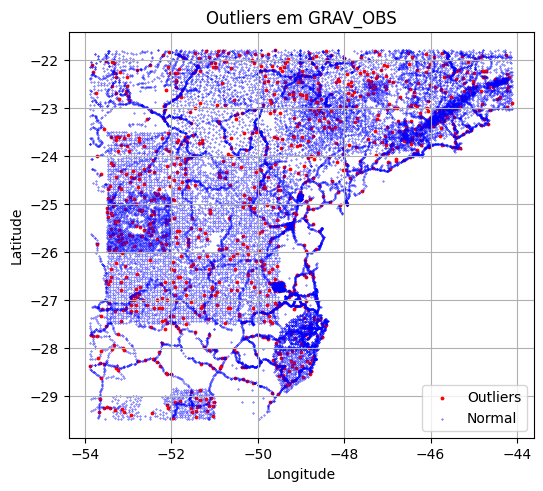

In [147]:
# Plotar os resultados
fig, ax = plt.subplots(figsize=(6, 6))
gdf_outliers_lof[gdf_outliers_lof['OUTLIER']].plot(ax=ax, color='red', label='Outliers', markersize=3)
gdf_outliers_lof[~gdf_outliers_lof['OUTLIER']].plot(ax=ax, color='blue', label='Normal', markersize=0.1)
plt.title("Outliers em GRAV_OBS")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

In [150]:
# Salvar o resultado em um novo shapefile
output_path = '/content/OUTPUT/grav_outliers_lof.shp'

gdf_outliers_lof[gdf_outliers_lof['OUTLIER']].to_file(output_path)

**Detecção de outliers usando Análise de Quartis (IQR - Interquartile Range)**

Executar a detecção de outliers usando IQR com otimização por arquitetura de árvore (BallTree)

In [ ]:
import time

Tempo de execução: 63.64 segundos


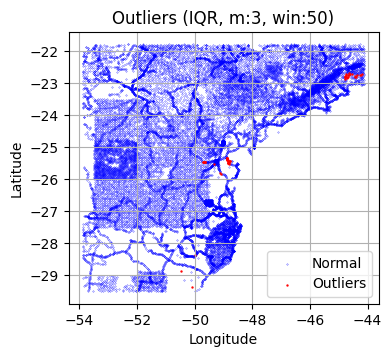

In [159]:

window_size_km = 50

start_time = time.time()
gdf_outliers_iqr = detect_outliers_iqr(gdf_corrigido, window_size_km=window_size_km, multiplier=3) #1.5 com janela 50 -> resultado a verificar
end_time = time.time()
print(f"Tempo de execução: {end_time - start_time:.2f} segundos")

# Separar dados normais e outliers
normal_gdf = gdf_outliers_iqr[gdf_outliers_iqr['OUTLIER'] == False]
outlier_gdf = gdf_outliers_iqr[gdf_outliers_iqr['OUTLIER'] == True]
outlier_gdf.head()

# Plot
fig, ax = plt.subplots(figsize=(4, 4))
normal_gdf.plot(ax=ax, color='blue', markersize=0.05, label='Normal')
outlier_gdf.plot(ax=ax, color='red', markersize=0.5, label='Outliers')
plt.title("Outliers (IQR, m:3, win:50)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.savefig("outliers_iqr_m3_win50.png", dpi=300, bbox_inches='tight')
plt.show()

Tempo de execução: 57.56 segundos


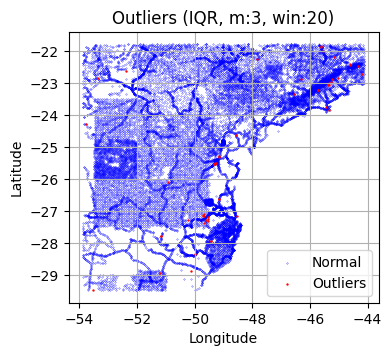

In [160]:
# Executar a detecção de outliers usando IQR com otimização por BallTree
window_size_km = 20

start_time = time.time()
gdf_outliers_iqr = detect_outliers_iqr(gdf_corrigido, window_size_km=window_size_km, multiplier=3) #1.5 com janela 50 -> resultado a verificar
end_time = time.time()
print(f"Tempo de execução: {end_time - start_time:.2f} segundos")

# Separar dados normais e outliers
normal_gdf = gdf_outliers_iqr[gdf_outliers_iqr['OUTLIER'] == False]
outlier_gdf = gdf_outliers_iqr[gdf_outliers_iqr['OUTLIER'] == True]
outlier_gdf.head()

# Plot
fig, ax = plt.subplots(figsize=(4, 4))
normal_gdf.plot(ax=ax, color='blue', markersize=0.05, label='Normal')
outlier_gdf.plot(ax=ax, color='red', markersize=0.5, label='Outliers')
plt.title("Outliers (IQR, m:3, win:20)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.savefig("outliers_iqr_m3_win20.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Salvar o 'gdf' como shapefile
output_path = '/content/OUTPUT/grav-final.shp'
normal_gdf.to_file(output_path)

# Compactar o shapefile para download
output_zip = '/content/OUTPUT/grav-final.zip'
with zipfile.ZipFile(output_zip, 'w') as zipf:
    for file in ['grav-final.shp', 'grav-final.shx',
                 'grav-final.dbf', 'grav-final.prj']:
        zipf.write(f'/content/OUTPUT/{file}', arcname=file)

# Fazer o download
files.download(output_zip)
print("Shapefile salvo e em download")

#**Visualização dos dados após análise**

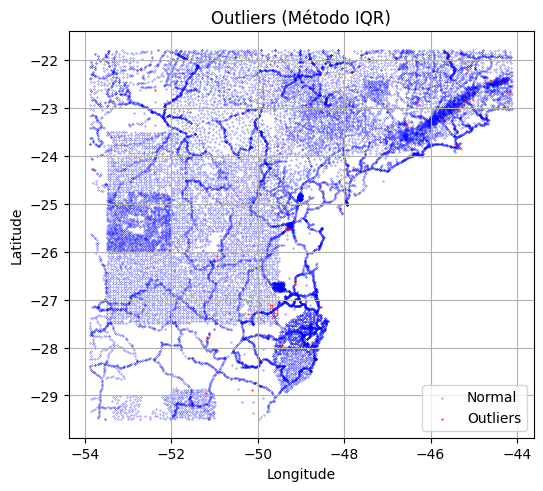

In [161]:
# Visualização 1: Outliers
fig, ax = plt.subplots(figsize=(6, 6))
normal_gdf.plot(ax=ax, color='blue', markersize=0.05, label='Normal')
outlier_gdf.plot(ax=ax, color='red', markersize=0.2, label='Outliers')
plt.title("Outliers (Método IQR)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

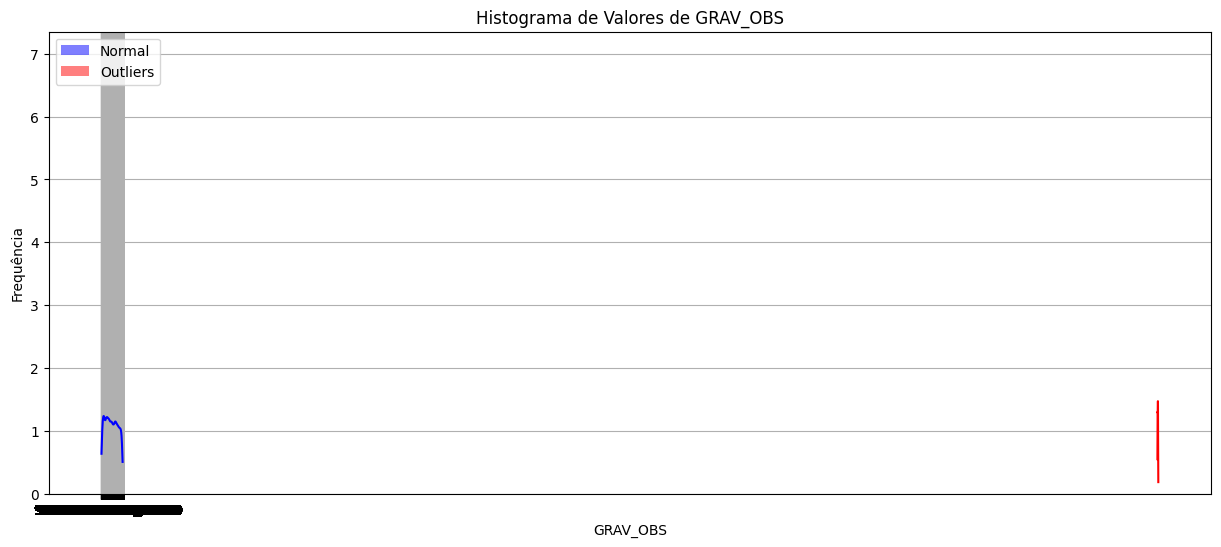

In [163]:
import seaborn as sns

# Visualização 2: Histograma de GRAV_OBS
plt.figure(figsize=(15, 6))
sns.histplot(gdf['GRAV_OBS'], bins=50, kde=True, color='blue', label='Normal')
sns.histplot(outlier_gdf['GRAV_OBS'], bins=50, kde=True, color='red', label='Outliers')
plt.title("Histograma de Valores de GRAV_OBS")
plt.xlabel("GRAV_OBS")
plt.ylabel("Frequência")
plt.legend()
plt.grid(True)
plt.show()